In [2]:
import scipy.io
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import random
from torchvision import transforms

mat = scipy.io.loadmat("./labels/0001.mat")
print(type(mat))
print(type(mat["groundtruth"]))
print(mat["groundtruth"].shape)
print(np.max(mat["groundtruth"]))


<class 'dict'>
<class 'numpy.ndarray'>
(832, 550)
55


In [3]:
mat = scipy.io.loadmat("./label_list.mat")
mat = mat["label_list"][0].tolist()
mat = [label[0] for label in mat]
print(mat)
class_count = len(mat)
print(class_count)

['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace', 'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']
59


In [4]:
img = cv2.imread("./photos/0001.jpg")
img = np.moveaxis(img, -1, 0)
print(img.shape)


(3, 832, 550)


In [5]:
"""
把資料拆訓練集和驗證集
"""
np.random.seed(9999)
idx = np.random.permutation(1000) + 1
training_idx = idx[:750]
testing_idx = idx[750:]


In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        """
        兩層 Convolution layer 疊在一起的 block
        """
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=1,
        features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2,
                    feature,
                    kernel_size=2,
                    stride=2,
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        """
        U-net down part
        """
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        """
        U-net bottleneck
        """
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        """
        U-net up part
        """
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)


def test():
    x = torch.randn((8, 3, 832, 550))
    model = UNET(in_channels=3, out_channels=59)
    preds = model(x)
    print(preds.shape)
    # assert preds.shape == x.shape


test()


torch.Size([8, 59, 832, 550])


In [7]:
zero_mat = []

for i in range(1000):
    file_number = "{:0>4d}".format(i + 1)
    test_label_image = scipy.io.loadmat(f"./labels/{file_number}.mat")["groundtruth"]
    if np.max(test_label_image) == 0:
        zero_mat.append(i)

print(zero_mat)


[535]


In [8]:
train_x = []
train_y = []

valid_x = []
valid_y = []

for idx in training_idx:
    if idx in zero_mat:
        continue

    file_number = "{:0>4d}".format(idx+1)

    img = cv2.imread(f"./photos/{file_number}.jpg")
    img = np.moveaxis(img, -1, 0)  # c, h, w
    train_x.append(img)

    label_image = scipy.io.loadmat(f"./labels/{file_number}.mat")["groundtruth"]
    train_y.append(label_image)

for idx in testing_idx:
    if idx in zero_mat:
        continue

    file_number = "{:0>4d}".format(idx)

    img = cv2.imread(f"./photos/{file_number}.jpg")
    img = np.moveaxis(img, -1, 0)
    valid_x.append(img)

    label_image = scipy.io.loadmat(f"./labels/{file_number}.mat")["groundtruth"]
    valid_y.append(label_image)

print(len(train_x), len(valid_x))


749 250


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

first_channel = 64
model = UNET(
    in_channels=3,
    out_channels=class_count,
    features=[first_channel, first_channel * 2, first_channel * 4, first_channel * 8],
).to(device)

"""
hyperparameters
"""
epochs = 500
batch_size = 6
learning_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [10]:
"""
測試
"""
x = torch.randn((3, 832, 550))
x = np.transpose(x, (1, 2, 0))
x_h = x.shape[0]
x_w = x.shape[1]
x = x.reshape(-1, 3)
print(x.shape)
x = x.reshape(x_h, x_w, 3)
print(x.shape)


x = torch.randn((59, 832, 550))
x = np.transpose(x, (1, 2, 0))
print(x.shape)


torch.Size([457600, 3])
torch.Size([832, 550, 3])
torch.Size([832, 550, 59])


In [11]:
"""
image normalization
"""
def normalize_image(numpy_img):
    numpy_img = np.moveaxis(numpy_img, 0, -1)
    trans_to_pil = transforms.ToPILImage()
    pil_img = trans_to_pil(numpy_img)

    """
    mean 和 std 不是這個資料集生出來的，而是取 ImageNet 的
    """
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            transforms.ToPILImage(),
        ]
    )

    pil_img = transform(pil_img)

    numpy_img = np.asarray(pil_img)
    numpy_img = np.moveaxis(numpy_img, -1, 0)
    return numpy_img


In [12]:
def data_augmentation(numpy_img, numpy_label):
    numpy_img = np.moveaxis(numpy_img, 0, -1)
    trans_to_pil = transforms.ToPILImage()
    pil_img = trans_to_pil(numpy_img)
    pil_label = trans_to_pil(numpy_label)

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    """
    horizental flip
    """
    if random.random() > 0.5:
        pil_img = TF.hflip(pil_img)
        pil_label = TF.hflip(pil_label)

    """
    affine
    """
    affine = transforms.RandomAffine
    affine_param = affine.get_params(
        degrees=[-30, 30],
        translate=[0, 0],
        scale_ranges=[1.0, 1.0],
        shears=[0, 0],
        img_size=list(numpy_label.shape),
    )
    pil_img = TF.affine(pil_img, *affine_param)
    pil_label = TF.affine(pil_label, *affine_param)

    """
    ColorJitter
    """
    jitter = transforms.Compose(
        [
            transforms.ColorJitter(
                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3
            ),
        ]
    )
    pil_img = jitter(pil_img)

    numpy_img = np.asarray(pil_img)
    numpy_img = np.moveaxis(numpy_img, -1, 0)

    numpy_label = np.asarray(pil_label)

    return numpy_img, numpy_label


In [13]:
def cal_loss(model, best_loss=[0], save_model=False, train_flag=False):
    with torch.no_grad():
        loss_list = []
        model.eval()

        inputs = valid_x if not train_flag else train_x
        labels = valid_y if not train_flag else train_y

        for idx in range(len(inputs)):
            input_image = normalize_image(inputs[idx])
            input_image = torch.tensor(input_image, dtype=torch.float32).to(
                device
            )  # c, h, w
            label_image = torch.tensor(labels[idx], dtype=torch.long).to(device)  # h, w

            """
            input preprocessing
            get output
            """
            input_h = input_image.shape[1]
            input_w = input_image.shape[2]

            outputs = model(input_image.unsqueeze(0))  # c, h, w -> b, class_count, h, w
            outputs = outputs.permute(0, 2, 3, 1)  # 1, h, w, class_count
            outputs = outputs.reshape(-1, class_count)  # h * w, class_count

            """
            label preprocessing
            """
            label_h = label_image.shape[0]
            label_w = label_image.shape[1]

            label_image = label_image.reshape(-1)

            loss = criterion(outputs, label_image.long())
            loss_list.append(loss)

        mean_loss = sum(loss_list) / len(loss_list)

        if save_model:
            if mean_loss < best_loss[0]:
                best_loss[0] = mean_loss
                torch.save(model.state_dict(), "model.pk1")

        return sum(loss_list) / len(loss_list)


In [14]:
model.load_state_dict(torch.load("4977.pk1"))


<All keys matched successfully>

In [ ]:
import random

print(f"init valid loss: {cal_loss(model)}")


best_loss = [1000000000]

for epoch_index, epoch in enumerate(range(epochs), 0):
    model.train()

    train_dataset = list(zip(train_x, train_y))
    random.shuffle(train_dataset)
    train_x, train_y = zip(*train_dataset)

    for idx in range(len(train_x)):
        input_image, label_image = train_x[idx], train_y[idx]

        # input_image, label_image = crop_space(input_image, label_image)
        input_image, label_image = data_augmentation(input_image, label_image)
        input_image = normalize_image(input_image)

        input_image = torch.tensor(input_image, dtype=torch.float32).to(
            device
        )  # c, h, w
        label_image = torch.tensor(label_image, dtype=torch.long).to(device)  # h, w

        """
        input preprocessing
        get output
        """
        input_h = input_image.shape[1]
        input_w = input_image.shape[2]

        outputs = model(input_image.unsqueeze(0))  # c, h, w -> b, class_count, h, w
        outputs = outputs.permute(0, 2, 3, 1)  # 1, h, w, class_count
        outputs = outputs.reshape(-1, class_count)  # h * w, class_count

        """
        label preprocessing
        """
        label_h = label_image.shape[0]
        label_w = label_image.shape[1]

        label_image = label_image.reshape(-1)

        if idx % batch_size == 0:
            optimizer.zero_grad()
            loss = criterion(outputs, label_image.long())
        else:
            loss += criterion(outputs, label_image.long())

        if (idx + 1) % batch_size == 0:
            loss.backward()
            optimizer.step()

    if epoch_index % 1 == 0:
        print(f"train loss: {cal_loss(model, train_flag =True)}")
        print(f"valid loss: {cal_loss(model, best_loss, save_model=True)}")


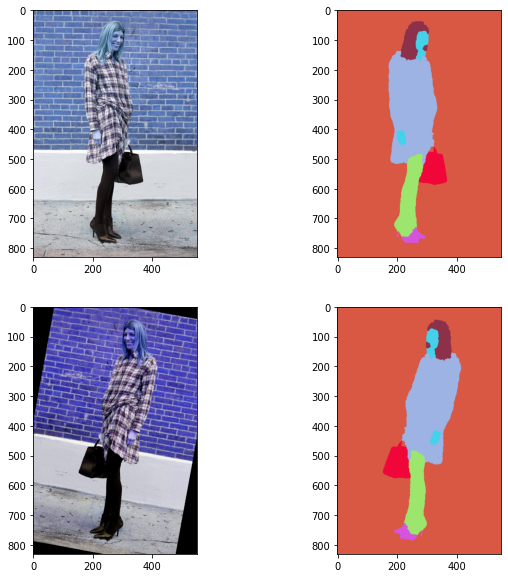

In [15]:
import matplotlib.pyplot as plt

test_idx = random.randrange(len(train_x))

input_image, label_image = train_x[test_idx], train_y[test_idx]

color_list = [np.random.randint(256, size=(3,)).tolist() for i in range(class_count)]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

input_image = np.moveaxis(input_image, 0, -1)
ax1.imshow(input_image)
input_image = np.moveaxis(input_image, -1, 0)

ans = np.zeros((label_image.shape[0], label_image.shape[1], 3), dtype=np.int16)
for i in range(label_image.shape[0]):
    for j in range(label_image.shape[1]):
        ans[i][j] = color_list[label_image[i][j]]

ax2.imshow(ans)

input_image, label_image = data_augmentation(input_image, label_image)
input_image = np.moveaxis(input_image, 0, -1)
ax3.imshow(input_image)


ans = np.zeros((label_image.shape[0], label_image.shape[1], 3), dtype=np.int16)
for i in range(label_image.shape[0]):
    for j in range(label_image.shape[1]):
        ans[i][j] = color_list[label_image[i][j]]

ax4.imshow(ans)


<Figure size 432x288 with 0 Axes>

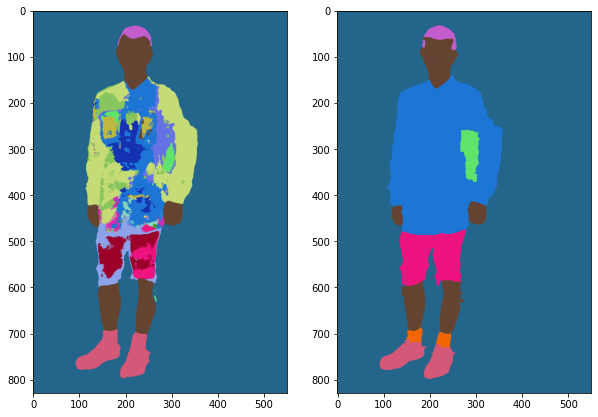

In [16]:
from skimage import io
from skimage import color
from skimage import segmentation
import matplotlib.pyplot as plt

def plot_valid_image(valid_idx=-1):
    if valid_idx == -1:
        valid_idx = random.randrange(len(valid_x))

    test_model = UNET(
        in_channels=3,
        out_channels=class_count,
        features=[first_channel, first_channel * 2, first_channel * 4, first_channel * 8],
    ).to(device)
    test_model = test_model.load_state_dict(torch.load("5387.pk1"))

    with torch.no_grad():
        test_idx = random.randrange(len(valid_x))
        input_image, label_image = valid_x[valid_idx], valid_y[valid_idx]

        input_image = normalize_image(input_image)
        input_image = torch.tensor(input_image, dtype=torch.float32).to(device)  # c, h, w
        label_image = torch.tensor(label_image, dtype=torch.long).to(device)  # h, w

        """
        input preprocessing
        get output
        """
        input_h = input_image.shape[1]
        input_w = input_image.shape[2]

        outputs = model(input_image.unsqueeze(0))

        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().detach().numpy()


        """
        change label to specific color
        """
        color_list = [
            np.random.randint(256, size=(3,)).tolist() for i in range(class_count)
        ]

        predicted = predicted.squeeze()

        img = np.zeros((predicted.shape[0], predicted.shape[1], 3), dtype=np.int16)
        for i in range(predicted.shape[0]):
            for j in range(predicted.shape[1]):
                img[i][j] = color_list[predicted[i][j]]

        plt.figure()
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 10))

        # print(img)
        ax1.imshow(img)

        label_image = label_image.cpu().detach().numpy()
        ans = np.zeros((label_image.shape[0], label_image.shape[1], 3), dtype=np.int16)
        for i in range(label_image.shape[0]):
            for j in range(label_image.shape[1]):
                ans[i][j] = color_list[label_image[i][j]]

        ax2.imshow(ans)
        plt.show()

plot_valid_image()


In [17]:
import torch.nn.functional as F

def mIOU(label, pred, num_classes=59):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    iou_list = list()
    present_iou_list = list()

    pred = pred.reshape(-1)
    label = label.reshape(-1)

    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    return np.mean(present_iou_list)


model = UNET(
    in_channels=3,
    out_channels=class_count,
    features=[first_channel, first_channel * 2, first_channel * 4, first_channel * 8],
).to(device)
model.load_state_dict(torch.load("5387.pk1"))
model.eval()

with torch.no_grad():
    valid_mean_iou_list = []
    for i in range(len(valid_x)):
        input_image, label_image = valid_x[i], valid_y[i]
        input_image = normalize_image(input_image)
        input_image = torch.tensor(input_image, dtype=torch.float32).to(device)  # c, h, w
        label_image = torch.tensor(label_image, dtype=torch.long).to(device)  # h, w

        # print(input_image.shape)
        outputs = model(input_image.unsqueeze(0))

        valid_mean_iou_list.append(mIOU(label_image, outputs))
    
    print(f"mean iou in valid set: {np.mean(valid_mean_iou_list)}")

mean iou in valid set: 0.42368170113135534


max mean IOU example


<Figure size 432x288 with 0 Axes>

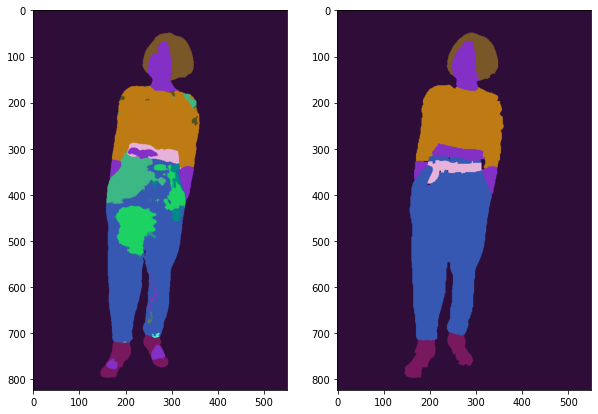

min mean IOU example


<Figure size 432x288 with 0 Axes>

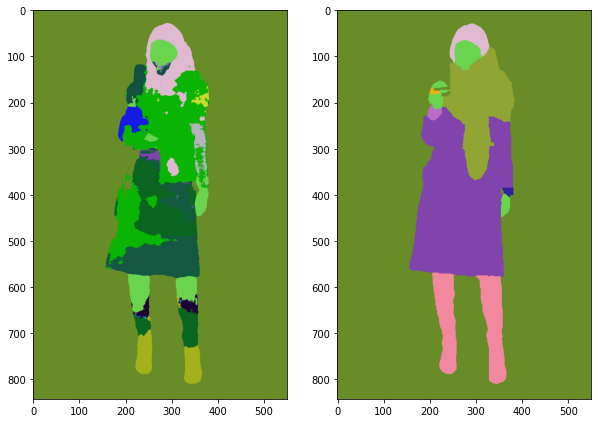

average mean IOU example


<Figure size 432x288 with 0 Axes>

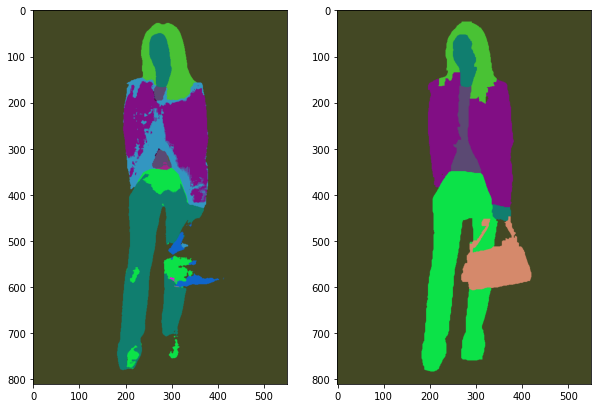

In [18]:
import matplotlib
matplotlib.interactive(False)

print(f"max mean IOU example")
plot_valid_image(np.argmax(valid_mean_iou_list))

print("min mean IOU example")
plot_valid_image(np.argmin(valid_mean_iou_list))

print("average mean IOU example")
plot_valid_image(np.argsort(valid_mean_iou_list)[len(valid_mean_iou_list)//2])